# Community Detection

_Realize that everything connects to everything else_ - Leonardo DaVinci


Concepts
- Industial Taxonomy
- Community Detection

References
- Gerard Hoberg and Gordon Phillips, 2016, Text-Based Network Industries and Endogenous Product Differentiation. Journal of Political Economy 124 (5), 1423-1465. 

In [1]:
import zipfile
import io
from itertools import chain
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from finds.database import SQL
from finds.readers import requests_get, Sectoring
from finds.structured import BusDay, PSTAT
from finds.recipes import graph_info
from secret import credentials
# %matplotlib qt
VERBOSE = 0

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
bd = BusDay(sql)
pstat = PSTAT(sql, bd, verbose=VERBOSE)

Last FamaFrench Date 2024-03-28 00:00:00


## Industry taxonomy

Industry classification, or industry taxonomy,
classifies companies into industrial groupings based on similar
production processes, products, or behavior in financial markets.


### TNIC

Hoberg and Phillips (2016) calculate firm-by-firm pairwise similarity scores by parsing the product descriptions from the firm 10Ks and forming word vectors for each firm, after basic screens to eliminate common words are applied. The words used only include nouns or proper nouns (see paper for details), and exclude geographic terms.
The cosine similarity score is computed as a continuous measure of product similarity for every pair of firms in our sample in each year, producing a pairwise similarity matrix.

These product descriptions are legally required to be accurate, as Item 101 
of Regulation S-K legally requires that firms describe the significant products they offer to the market, and these descriptions 
must also be updated and representative of the current fiscal year of the 10-K. Hence a a Text Based Industry Classification (TNIC) scheme, derived from the textual similarity of product descriptions, may better reflect firms' changes in the product market space over time.

Source: https://hobergphillips.tuck.dartmouth.edu/industryclass.htm

In [3]:
# Retrieve TNIC scheme from Hoberg and Phillips website
tnic_scheme = 'tnic3'
root = 'https://hobergphillips.tuck.dartmouth.edu/idata/'   
source = root + tnic_scheme + '_data.zip'
if source.startswith('http'):
    response = requests_get(source)
    source = io.BytesIO(response.content)

# extract the csv file from zip archive
with zipfile.ZipFile(source).open(tnic_scheme + "_data.txt") as f:
    tnic_data = pd.read_csv(f, sep='\s+')

# extract one year of tnic as data frame
year = max(tnic_data['year']) # [1989, 1999, 2009, 2019]
tnic = tnic_data[tnic_data['year'] == year].dropna()
tnic

,year,gvkey1,gvkey2,score
24633638,2021,1004,1210,0.0085
24633639,2021,1004,1823,0.0071
24633640,2021,1004,2285,0.0077
24633641,2021,1004,4091,0.0339
24633642,2021,1004,9698,0.0039
...,...,...,...,...
25478201,2021,349972,322154,0.0444
25478202,2021,349972,331856,0.0169
25478203,2021,349972,332115,0.0214
25478204,2021,349972,345556,0.0781


### Industry classification

TODO
- SIC, 2-digit, 3-, 4-
- NAICS, 2, 3, 4, 5, 6


In [4]:
# populate dataframe of nodes with gvkey (as index), permno, sic and naics
nodes = DataFrame(index=sorted(set(tnic['gvkey1']).union(tnic['gvkey2'])))\
        .rename_axis(index='gvkey')
for code in ['lpermno', 'sic', 'naics']:
    lookup = pstat.build_lookup('gvkey', code, fillna=0)
    nodes[code] = lookup(nodes.index)
Series(np.sum(nodes > 0, axis=0)).rename('Non-missing').to_frame().T

,lpermno,sic,naics
Non-missing,4218,4218,4216


In [5]:
# supplement naics and sic with crosswalks in Sectoring class
naics = Sectoring(sql, 'naics', fillna=0)   # supplement from crosswalk
sic = Sectoring(sql, 'sic', fillna=0)
nodes['naics'] = nodes['naics'].where(nodes['naics'] > 0, naics[nodes['sic']])
nodes['sic'] = nodes['sic'].where(nodes['sic'] > 0, sic[nodes['naics']])
Series(np.sum(nodes > 0, axis=0)).rename('Non-missing').to_frame().T 

,lpermno,sic,naics
Non-missing,4218,4218,4218


### Sectors

An industry taxonomy may include detailed classifications, and groupings into
broader sector
- Fama and French group 4-digit SIC codes into broader groups of 5, 10, 12, 17, 30, 38, 48, or 49 industry sectors.
- The Bureau of Economic Analysis groups 6-digit NAICS codes into a few dozen "summary" level groups, using definitions that were updated in 1947, 1963 and 1997.


In [6]:
# include sectoring schemes
codes = {'sic': ([f"codes{c}" for c in [5, 10, 12, 17, 30, 38, 48, 49]]
                 + ['sic2', 'sic3']),
         'naics': ['bea1947', 'bea1963', 'bea1997']}
sectorings = {}   # store Sectoring objects
for key, schemes in codes.items():
    for scheme in schemes:
        if scheme not in sectorings:

            # missing value is integer 0 sic2 and sic3 shemes, else string ''
            fillna = 0 if scheme.startswith('sic') else ''

            # load the sectoring class from SQL
            sectorings[scheme] = Sectoring(sql, scheme, fillna=fillna)

            # apply the sectoring scheme to partition the nodes
            nodes[scheme] = sectorings[scheme][nodes[key]]

        # keep nodes with non-missing data
        nodes = nodes[nodes[scheme].ne(sectorings[scheme].fillna)]
        print(len(nodes), scheme)
nodes

4259 codes5
4259 codes10
4259 codes12
4259 codes17
4259 codes30
4259 codes38
4259 codes48
4259 codes49
4218 sic2
4218 sic3
3943 bea1947
3943 bea1963
3943 bea1997


,lpermno,sic,naics,codes5,codes10,codes12,codes17,codes30,codes38,codes48,codes49,sic2,sic3,bea1947,bea1963,bea1997
gvkey,,,,,,,,,,,,,,,,
1004,54594,5080,423860,Cnsmr,Shops,Shops,Machn,Whlsl,Whlsl,Whlsl,Whlsl,50,508,42,42,42
1045,21020,4512,481111,Other,Durbl,Durbl,Trans,Trans,Trans,Trans,Trans,45,451,48,481,481
1050,11499,3564,333413,Manuf,Manuf,Manuf,Machn,FabPr,Machn,Mach,Mach,35,356,333,333,333
1076,10517,6141,522220,Other,Other,Money,Finan,Fin,Money,Banks,Banks,61,614,52,521CI,521CI
1078,20482,3845,334510,Hlth,Hlth,Hlth,Other,Hlth,Instr,MedEq,MedEq,38,384,334,334,334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345556,16069,2836,325414,Hlth,Hlth,Hlth,Other,Hlth,Chems,Drugs,Drugs,28,283,325,325,325
345920,20194,3524,333112,Manuf,Manuf,Manuf,Machn,FabPr,Machn,Mach,Mach,35,352,333,333,333
345980,20333,5961,455110,Cnsmr,Shops,Shops,Rtail,Rtail,Rtail,Rtail,Rtail,59,596,44RT,44RT,4A0


In [7]:
# populate undirected graph with tnic edges
edges = tnic[tnic['gvkey1'].isin(nodes.index) & tnic['gvkey2'].isin(nodes.index)]
edges = list(
    edges[['gvkey1', 'gvkey2', 'score']].itertuples(index=False, name=None))
G = nx.Graph()
G.add_weighted_edges_from(edges)
G.remove_edges_from(nx.selfloop_edges(G))  # remove self-loops: not necessary
Series(graph_info(G, fast=True)).rename(year).to_frame()

,2021
transitivity,0.874473
average_clustering,0.585098
connected,False
connected_components,8
size_largest_component,3908
directed,False
weighted,True
negatively_weighted,False
edges,405305
nodes,3925


## Community structure

TODO


### Measuring partitions

TODO


In [8]:
# evaluate modularity of sectoring schemes on TNIC graph
def community_quality(G, communities):
    """helper to measure quality of partitions"""
    out = {'communities': len(communities)}
    out['modularity'] = nx.community.modularity(G, communities)
    (out['coverage'],
     out['performance']) = nx.community.partition_quality(G, communities)    
    return out

In [9]:
modularity = {}   # to collect measurements of each scheme
for scheme in sorted(chain(*codes.values())):
    communities = nodes.loc[list(G.nodes), scheme]\
                       .reset_index()\
                       .groupby(scheme)['gvkey']\
                       .apply(list)\
                       .to_list()    # list of lists of node labels
    modularity[scheme] = community_quality(G, communities)
df = DataFrame.from_dict(modularity, orient='index').sort_index()
print(f"Quality of sectoring schemes on TNIC graph ({year})")
df

Quality of sectoring schemes on TNIC graph (2021)


,communities,modularity,coverage,performance
bea1947,40,0.337511,0.791471,0.928649
bea1963,58,0.331096,0.748338,0.950073
bea1997,61,0.331030,0.748153,0.950577
codes10,10,0.340272,0.938264,0.850497
codes12,12,0.340412,0.931380,0.879861
codes17,17,0.278554,0.737459,0.788439
codes30,30,0.339191,0.927052,0.900273
codes38,36,0.339822,0.803928,0.893095
codes48,48,0.337848,0.765192,0.946618
codes49,49,0.337751,0.764032,0.952728


### Detecting partitions

TODO


In [10]:
# Run community detection algorithms
def community_detection(G):
    """Helper to run community detection algorithms on an undirected graph"""
    out = {}
    out['label'] = nx.community.label_propagation_communities(G)
    out['louvain'] = nx.community.louvain_communities(G, resolution=1)
    out['greedy'] = nx.community.greedy_modularity_communities(G, resolution=1)
    return out

In [11]:
communities = community_detection(G)
quality = {}
for key, community in communities.items():
    quality[key] = community_quality(G, community)

In [12]:
df = DataFrame.from_dict(quality, orient='index').sort_index()
print(f"Modularity of community detection algorithms on TNIC graph ({year})")
df

Modularity of community detection algorithms on TNIC graph (2021)


,communities,modularity,coverage,performance
greedy,26,0.347560,0.982830,0.507290
label,109,0.355460,0.990437,0.906120
louvain,19,0.363978,0.835415,0.823403


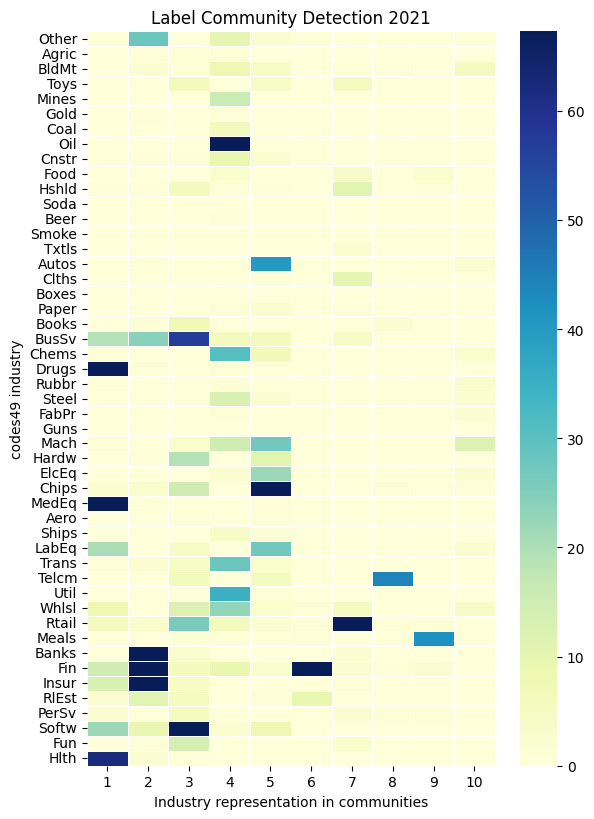

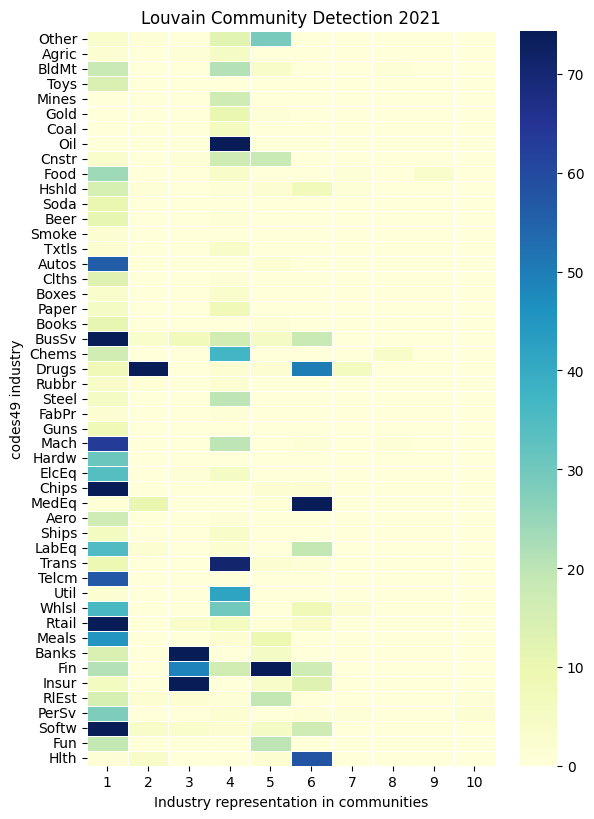

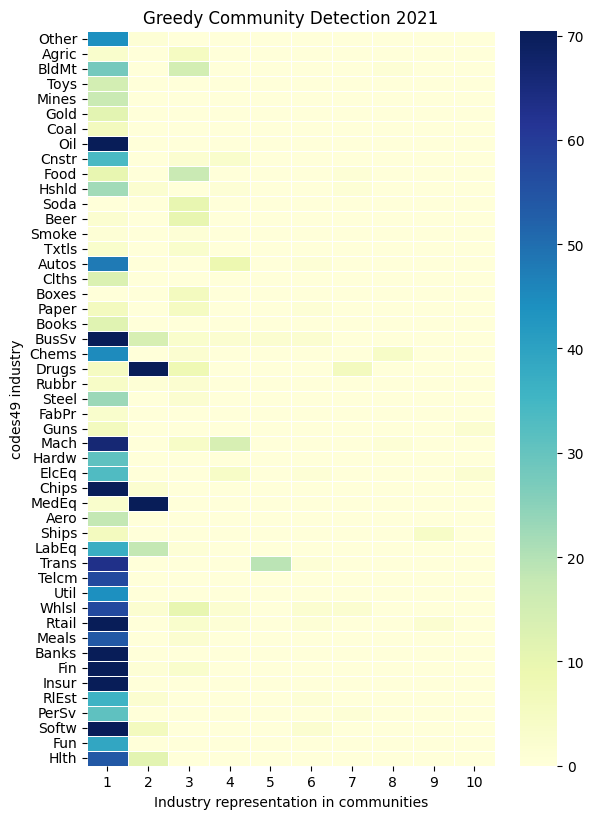

In [13]:
# Visualize Fama-French 49-industries in the detected communities
key = 'codes49'
for ifig, detection in enumerate(communities.keys()):

    # count industries represented in each partition
    industry = []
    communities_sequence = sorted(communities[detection], key=len, reverse=True)    
    for i, community in enumerate(communities_sequence):
        industry.append(nodes[key][list(community)].value_counts().rename(i+1))
    names = sectorings[key].sectors['name'].drop_duplicates(keep='first')
    df = pd.concat(industry, axis=1)\
           .dropna(axis=0, how='all')\
           .fillna(0)\
           .astype(int)\
           .reindex(names)

    # display as heatmap
    fig, ax = plt.subplots(num=ifig+1, clear=True, figsize=(6, 8))
    sns.heatmap(df.iloc[:,:10],
                square=False,
                linewidth=.5,
                ax=ax,
                yticklabels=1,
                cmap="YlGnBu",
                robust=True)
    if scheme.startswith('bea'):
        ax.set_yticklabels(Sectoring._bea_industry[df.index], size=10)
    else:
        ax.set_yticklabels(df.index, size=10)
    ax.set_title(f'{detection.capitalize()} Community Detection {year}')
    ax.set_xlabel(f"Industry representation in communities")
    ax.set_ylabel(f"{key} industry")
    fig.subplots_adjust(left=0.4)
    plt.tight_layout(pad=0)
